In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.3MB/s 
     |████████████████████████████████| 194kB 34.4MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 1.2MB 26.9MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

# CNN Interpretation with CAM

## CAM and Hooks

In [3]:
path = untar_data(URLs.PETS)/'images'
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.136700,0.036480,0.010825,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.076766,0.026159,0.005413,00:44


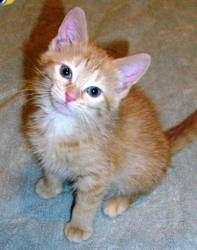

In [6]:
PILImage.create(image_cat())

In [7]:
img = PILImage.create(image_cat())
x, = first(dls.test_dl([img]))

In [8]:
x.shape

torch.Size([1, 3, 224, 224])

In [10]:
class Hook():
    def hook_func(self, m, i, o): 
      self.stored = o.detach().clone()

In [14]:
hook_output = Hook()

In [15]:
learn.model[0] # the body

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [16]:
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [17]:
with torch.no_grad(): 
  output = learn.model.eval()(x)

In [20]:
act = hook_output.stored[0]

In [19]:
hook_output.stored.shape

torch.Size([1, 512, 7, 7])

512 channels/filters after the convolution layer. grid size is 7x7

In [21]:
F.softmax(output, dim=-1)

tensor([[4.3673e-08, 1.0000e+00]], device='cuda:0')

In [22]:
dls.vocab

[False, True]

In [23]:
x.shape

torch.Size([1, 3, 224, 224])

In [24]:
act.shape

torch.Size([512, 7, 7])

In [29]:
learn.model[1] # head part

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [32]:
learn.model[1][-1].weight.shape

torch.Size([2, 512])

can take weights only for the last layer.
and activations of the head.

In [33]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 7, 7])

In [38]:
len(dls.train.decode((x,)))

1

In [40]:
dls.train.decode((x,))[0].shape

torch.Size([1, 3, 224, 224])

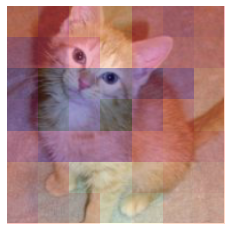

In [47]:
x_dec = TensorImage(dls.train.decode((x,))[0][0]) # take only the first image
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.4, extent=(0,224,224,0),
             cmap='magma');

'\n    extent : scalars (left, right, bottom, top), optional\n    The bounding box in data coordinates that the image will fill.\n    The image is stretched individually along x and y to fill the box.\n'

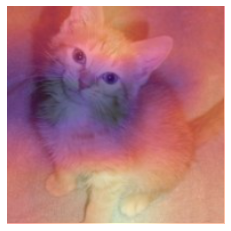

In [55]:
x_dec = TensorImage(dls.train.decode((x,))[0][0]) # take only the first image
_,ax = plt.subplots()
x_dec.show(ctx=ax)
# cam_map[1] # weights for cat
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
             cmap='magma', interpolation='bilinear');
"""
    extent : scalars (left, right, bottom, top), optional
    The bounding box in data coordinates that the image will fill.
    The image is stretched individually along x and y to fill the box.
"""

In [53]:
ax.imshow?

In [56]:
hook.remove()

In [58]:
class Hook():
    def __init__(self, m):
      self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): 
      self.stored = o.detach().clone()
    def __enter__(self, *args): 
      return self
    def __exit__(self, *args): 
      self.hook.remove()

In [59]:
with Hook(learn.model[0]) as hook:
    with torch.no_grad(): 
      output = learn.model.eval()(x.cuda())
    act = hook.stored

## Gradient CAM

In [61]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [62]:
cls = 1 # for cat
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored # returning body and head outs
    output[0,cls].backward() # index 0 is the body of the model.. we already storef body o[0]
    grad = hookg.stored

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [88]:
output.shape

torch.Size([1, 2])

In [89]:
output

tensor([[-9.0853,  7.8613]], device='cuda:0', grad_fn=<MmBackward>)

In [65]:
act.shape

torch.Size([1, 512, 7, 7])

In [66]:
grad.shape

torch.Size([1, 512, 7, 7])

it works cos gradient with respect to activation is the weight!

In [67]:
w = grad[0].mean(dim=[1,2], keepdim=True) # mean over 7*7 to return 512,1,1
cam_map = (w * act[0]).sum(0)

In [68]:
w.shape, act[0].shape

(torch.Size([512, 1, 1]), torch.Size([512, 7, 7]))

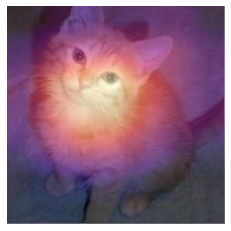

In [69]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

For just an individual layer

In [85]:
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [86]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

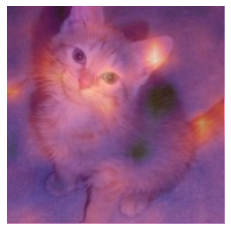

In [87]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

## Conclusion

## Questionnaire

1. What is a "hook" in PyTorch?
1. Which layer does CAM use the outputs of?
1. Why does CAM require a hook?
1. Look at the source code of the `ActivationStats` class and see how it uses hooks.
1. Write a hook that stores the activations of a given layer in a model (without peeking, if possible).
1. Why do we call `eval` before getting the activations? Why do we use `no_grad`?
1. Use `torch.einsum` to compute the "dog" or "cat" score of each of the locations in the last activation of the body of the model.
1. How do you check which order the categories are in (i.e., the correspondence of index->category)?
1. Why are we using `decode` when displaying the input image?
1. What is a "context manager"? What special methods need to be defined to create one?
1. Why can't we use plain CAM for the inner layers of a network?
1. Why do we need to register a hook on the backward pass in order to do Grad-CAM?
1. Why can't we call `output.backward()` when `output` is a rank-2 tensor of output activations per image per class?

### Further Research

1. Try removing `keepdim` and see what happens. Look up this parameter in the PyTorch docs. Why do we need it in this notebook?
1. Create a notebook like this one, but for NLP, and use it to find which words in a movie review are most significant in assessing the sentiment of a particular movie review.